In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import read_topology, TopologyNode
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree, plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.statistics import gelman_rubin
from hyperiax.mcmc.plotting import trace_plots

from hyperiax_internal_data.examples.SDE import dts, dot, solve, forward
from hyperiax_internal_data.examples.ABFFG import *
from hyperiax_internal_data.examples.shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

In [19]:
n_steps = 25 # number of time steps in the discretization

 # drift
def b(t,x,params): return jnp.zeros(n*d)

# diffusion and covariance specification for shape processes
# assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix

kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance

/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/male_dataset/species_tree.tre
HypTree(size=1220, levels=43, leaves=610, inner nodes=609)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

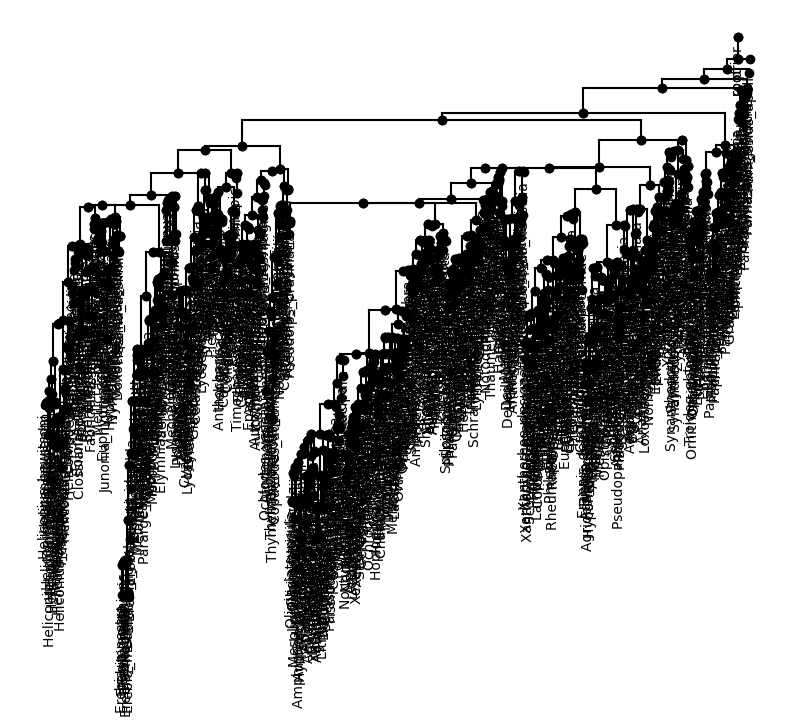

In [20]:
import pandas as pd

# data and landmarks dimensions
d = 2

#filename = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/papilio_male_dataset/papilio_tree.tree"
#filename_csv = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/papilio_male_dataset/papilio_shapes.csv"
filename = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/male_dataset/species_tree.tre"
filename_csv = "hyperiax_internal_data/data/butterflies/male_dataset/reconstructed_shapes.csv"
print(filename)

with open(filename, "r") as file:
    string_tree = file.read()
data_tree = read_topology(string_tree)
topology = data_tree.topology_root
# add additional root node
root = TopologyNode(parent=None,children=[topology])
topology.parent = root
root.name = "prior"; topology.name = "root"
tree = HypTree(root)
# copy edge lengths and (prior) root edge length
tree.add_property('edge_length', shape=())
tree.data['edge_length'] = tree.data['edge_length'].at[1:].set(data_tree.data['edge_length'][:,0])
tree.data['edge_length'] = tree.data['edge_length'].at[1].set(jnp.mean(2*data_tree.data['edge_length']))

#for i,node in enumerate(tree.iter_topology_bfs()):
#    node.name = str(f'xx_{i}')

# print the tree
print(tree)
plot_tree_text(tree)
plot_tree(tree,inc_names=True)

                            1          2          3          4           5    \
node_names                                                                     
root                  15.441673  81.369300  22.379480  96.336876   31.368105   
                      15.309563  81.498020  22.616870  96.222850   31.160755   
Parnassius_apollo     32.807860  50.729790  45.891010  63.644417   56.980858   
                      15.283045  81.593620  22.664806  96.355030   31.087585   
Parnassius_smintheus  29.182882  47.915085  41.634220  60.389008   50.692184   
...                         ...        ...        ...        ...         ...   
Noctua_fimbriata      56.626804  56.809326  61.125400  70.159110   63.977695   
Noctua_janthina       88.785510  75.660650  95.818560  87.229290  102.699425   
Noctua_janthe         53.565193  63.376434  60.453354  74.843270   65.131660   
Oligia_latruncula     55.667564  64.056150  64.815605  72.325980   70.854480   
Oligia_strigilis      55.156933  61.9029

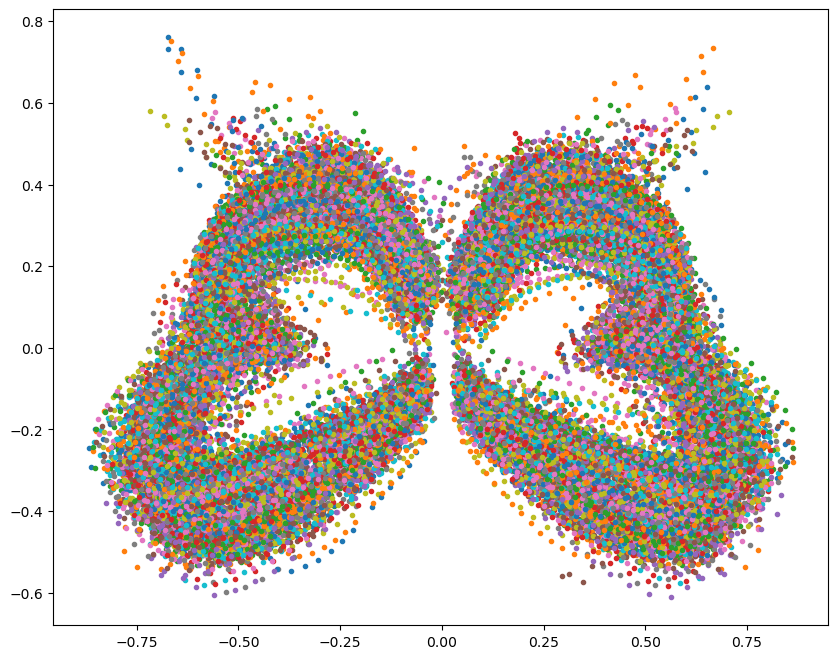

In [22]:
# load landmarks into tree (note they are sorted, from they estimation of the shapes in the tree)
# add landmarks

landmarks = pd.read_csv(filename_csv, sep=",", header=None)
if 'male_dataset' in filename_csv: # reorder to match 
    node_names= [ node.name for node in list(tree.iter_topology_bfs())]

    # Because we have renamed the root, local change here
    #node_names[1] = "xx_0"
    
    landmarks['node_names'] = node_names

    # Set the node_names column as the index before reindexing
    landmarks = landmarks.set_index('node_names')
    #landmarks = landmarks.reindex(node_names) # And we skip the prior 
    landmarks = landmarks[1:]

    # Remove the column with edges
    landmarks = landmarks.drop(columns=0)
    print(landmarks)
    
    
landmarks = landmarks.to_numpy()
# Check for NaN values in landmarks array
nan_rows = jnp.where(jnp.isnan(landmarks).any(axis=1))[0]
if len(nan_rows) > 0:
    print("Warning: NaN values found in landmarks array at row(s):", nan_rows)
    
n = landmarks.shape[1]//d
print("n landmarks: ",n)
if 'male_dataset' in filename_csv:
    landmarks = landmarks.reshape((-1,n,d))
    landmarks = jnp.delete(landmarks,66,axis=1) # drop row with coinciding landmarks
    landmarks = landmarks.reshape((landmarks.shape[0],-1))
    n = landmarks.shape[1]//d
    print("n landmarks after removing coinciding landmarks: ",landmarks.shape)
    
print(landmarks)
## subsample landmarks
#landmarks = landmarks.reshape((-1,n,d)); landmarks = landmarks[:,::4,:].reshape((landmarks.shape[0],-1)); n = landmarks.shape[1]//d
#print("n landmarks after subsampling: ",n)

# scale and possibly downsample landmarks
n_shapes = landmarks.shape[0]
landmarks = 2*1e-3*landmarks.reshape((n_shapes,-1,d))[:,::1].reshape((n_shapes,-1))

# add landmarks to tree 
tree.add_property('value', shape=(n_steps+1,n*d,))
tree.data['value'] = tree.data['value'].at[1:].set(landmarks[:,None,:])
leaf_values = tree.data['value'][tree.is_leaf][:,-1]

# add noise to tree 
tree.add_property('noise', shape=(n_steps,n*d))

# set prior root value
tree.data['value'] = tree.data['value'].at[0].set(jnp.mean(leaf_values,0))

# plot
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1],ax=ax)
plot_shape_2d(tree.data['value'][0][0],ax=ax)

Shape 441 has minimum distance 0.001 between landmarks 110 and 112


Text(0.5, 1.0, 'Shape 441 - Min distance: 0.001')

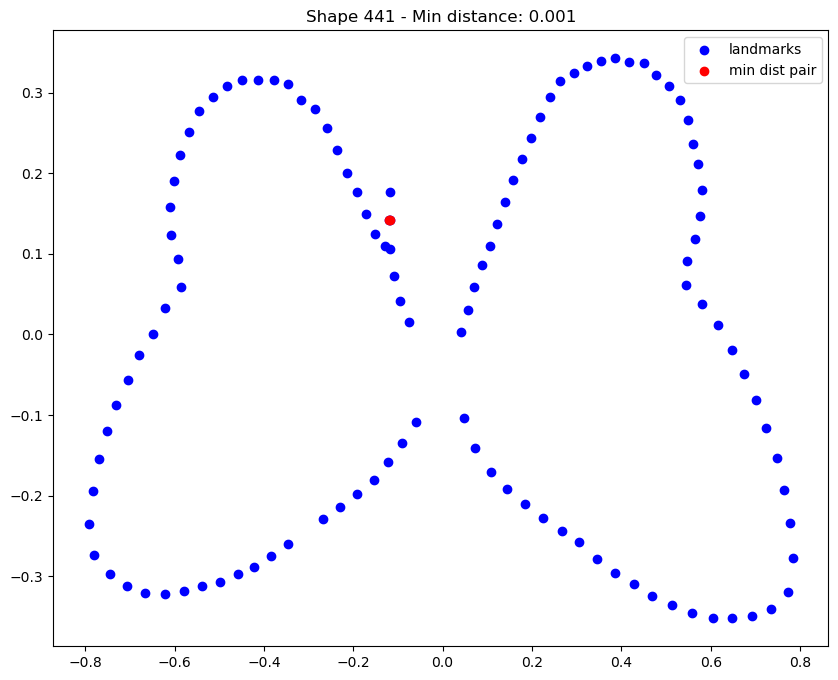

In [23]:
# compute pairwise distances between landmarks for each shape
def compute_min_dist(shape):
    # reshape to (n,d)
    shape_2d = shape.reshape(-1,d)
    # compute pairwise distances
    dists = jnp.sqrt(jnp.sum((shape_2d[:,None,:]-shape_2d[None,:,:])**2,axis=2))
    # mask diagonal with large value instead of inf to avoid nans
    dists = dists+jnp.eye(shape_2d.shape[0])*1e10
    # find minimum distance and indices
    min_dist = jnp.min(dists)
    i,j = jnp.unravel_index(jnp.argmin(dists),dists.shape)
    return min_dist,i,j

# compute for all shapes
min_dists = []
min_pairs = []
for leaf in tree.iter_topology_leaves_bfs():
    min_dist,i,j = compute_min_dist(tree.data['value'][leaf.id,-1])
    min_dists.append(min_dist)
    min_pairs.append((i,j))

# find shape with minimum distance
leaf_idx = jnp.argmin(jnp.array(min_dists))
min_pair = min_pairs[leaf_idx]
# print shape index and problematic landmark indices
print(f"Shape {leaf_idx} has minimum distance {min_dists[leaf_idx]:.3f} between landmarks {min_pair[0]} and {min_pair[1]}")


# plot shape with minimum distance pair highlighted
fig,ax = plt.subplots(figsize=(10,8))
shape = leaf_values[leaf_idx].reshape(-1,d)
# plot all points
ax.scatter(shape[:,0],shape[:,1],c='blue',label='landmarks')
# highlight minimum distance pair
ax.scatter(shape[min_pair,0],shape[min_pair,1],c='red',label='min dist pair')
ax.plot(shape[min_pair,0],shape[min_pair,1],'r-')
ax.legend()
ax.set_title(f'Shape {leaf_idx} - Min distance: {min_dists[leaf_idx]:.3f}')

In [24]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.05), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

In [25]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps); _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs = forward(parent_value.reshape((-1,n*d))[-1],_dts,_dWs,b,sigma,params)
        return {'value': Xs}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

In [26]:
# sample new noise
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

In [27]:
if tree.depth < 10:
    fig,ax = plt.subplots(figsize=(10,8))
    plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
    plt.gca().set_title('Sampled tree without leaf noise')

    plot_tree_2d_shape(tree,'value')

In [28]:
# backwards filter
@jax.jit
def up(noise,edge_length,F_T,H_T,tildea,params,**args):
    def f(edge_length,F_T,H_T,tildea):
        var = edge_length # variance is edge length
        T = var # running time of Brownian motion

        _ts = jnp.cumsum(jnp.concatenate((jnp.array([0.]), dts(T=T,n_steps=n_steps))))[:-1]
        Phi_inv = lambda t:  jnp.eye(n)+H_T@tildea*(T-t)
        H_0 = solve(Phi_inv(0),H_T).reshape(H_T.shape)
        F_0 = solve(Phi_inv(0),F_T).reshape(F_T.shape)
        v_T = solve(H_T,F_T)
        
        c_0 = jax.vmap(lambda v_T: logphi_H(jnp.zeros(n),v_T,H_0),1)(v_T.reshape((n,d)))
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(edge_length,F_T,H_T,tildea)
def transform(child_c_0,child_F_0,child_H_0,params,**args):
    F_T = child_F_0
    H_T = child_H_0
    c_T = child_c_0
    v_T = jax.vmap(lambda H,F: solve(H,F))(H_T,F_T)
    tildea = jax.vmap(lambda v: a(v,params))(v_T)
    return {'c_T': c_T, 'F_T': F_T, 'H_T': H_T, 'tildea': tildea}
upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'c_0': 'sum',
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

In [29]:
# initialize tree for up
tree.add_property('c_0', shape=(d,)); tree.add_property('F_0', shape=(n*d,)); tree.add_property('H_0', shape=(n,n)); tree.add_property('c_T', shape=(d,)); tree.add_property('F_T', shape=(n*d,)); tree.add_property('H_T', shape=(n,n)); tree.add_property('logpsi'); tree.add_property('tildea', shape=(n,n))
def init_up(leaf_values,params):
    tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(tree.data['value'][tree.is_leaf].at[:,-1].set(leaf_values))
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(n)/params['obs_var'].value)[None,:,:])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jax.vmap(lambda H,v: dot(H,v))(tree.data['H_T'][tree.is_leaf],leaf_values))
    Sigma = params['obs_var'].value*jnp.eye(n)
    tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(jax.vmap(lambda v: jax.vmap(lambda v: logphi(jnp.zeros(n),v,Sigma),1)(v.reshape((n,d))))(leaf_values))
    tree.data['tildea'] = tree.data['tildea'].at[tree.is_leaf].set(jax.vmap(lambda v: a(v,params.values()))(leaf_values))

In [30]:
@jax.jit
def down_conditional(noise,edge_length,F_T,H_T,tildea,parent_value,params,**args):
    def f(noise,edge_length,F_T,H_T,tildea,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps)
        _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs,logpsi = forward_guided(parent_value.reshape((-1,n*d))[-1],H_T,F_T,tildea,_dts,_dWs,b,sigma,params)
        return {'value': Xs, 'logpsi': logpsi}

    return jax.vmap(f)(noise,edge_length,F_T,H_T,tildea,parent_value)
downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)

In [31]:
# backwards filter and fowards guiding
init_up(leaf_values,params)
up.up(tree,params.values())
down_conditional.down(tree,params.values())

# time the operations
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())
%time down_unconditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time down_conditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time up.up(tree,params.values()); jax.block_until_ready(tree.data['H_0'])
None

CPU times: user 14min 21s, sys: 42.4 s, total: 15min 4s
Wall time: 2min 9s
CPU times: user 13min 48s, sys: 39.5 s, total: 14min 27s
Wall time: 2min 1s
CPU times: user 1min, sys: 6.36 s, total: 1min 7s
Wall time: 11.3 s


In [ ]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# log likelihood of the tree under the Gaussian approximation with correction factors
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,noise = state
    # backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())
    # forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    v,c,F,H = tree.data['value'][tree.is_root][:,0],tree.data['c_T'][tree.is_root],tree.data['F_T'][tree.is_root],tree.data['H_T'][tree.is_root]
    v = jnp.squeeze(v); c = jnp.squeeze(c); F = jnp.squeeze(F); H = jnp.squeeze(H)
    tree_log_likelihood = c.sum()+F@v-.5*v.T@dot(H,v)
    tree_logpsi = jnp.mean(tree.data['logpsi'][1:])
    residuals = tree.data['value'][tree.is_leaf][:,-1]-data
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+tree_logpsi+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters,new_noise

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.25,alpha=3,beta=.1), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25,alpha=3,beta=.1,max=1.), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise variance
    })
print("Initial parameters: ",init_params.values())

# initial state
init_state = (init_params,jnp.zeros_like(tree.data['noise']))

# Run Metropolis-Hastings
n_chains = 4
from dask.distributed import Client, LocalCluster
n_workers = min(n_chains,8)

# Try to connect to existing cluster, create new one if none exists
try:
    client = Client("tcp://localhost:8787",timeout=5)
except OSError:
    cluster = LocalCluster(n_workers=n_workers)
    client = Client(cluster)

# Run parallel chains
subkey, key = split(key)
subkeys = jax.random.split(key, n_chains)  # One key per chain

import warnings
import copy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")
    futures = []
    for i in range(n_chains):  # 4 chains
        key, subkey = split(subkeys[i])
        chain_init_state = (init_params.propose(key),init_state[1])
        future = client.submit(metropolis_hastings, log_posterior, proposal, leaf_values,
                             chain_init_state, 200, burn_in=0, rng_key=subkey,
                             savef=lambda state: state[0])
        futures.append(future)

# Gather results from all chains
results = client.gather(futures)
log_likelihoods = [r[0] for r in results]  # Extract log likelihoods from each chain
samples = [r[1] for r in results]  # Extract samples from each chain

# plot log likelihoods for each chain
plt.figure(figsize=(10,6))
for k in range(n_chains):
    plt.plot(log_likelihoods[k], label=f'Chain {k+1}')
plt.xlabel("Iterations")
plt.ylabel("Log Likelihood")
plt.title('Log likelihood per chain')
plt.legend()
plt.show()

# plot trace plots for each chain
for k in range(n_chains):
    print(f"\nChain {k+1}:")
    trace_plots([samples[k][i] for i in range(len(samples[k]))])
    print(f"Final parameters for chain {k+1}: ", samples[k][-1].values())


# Calculate and print R-hat values
r_hats = gelman_rubin(samples)
print("\nGelman-Rubin Statistics (R-hat):")
for param,r_hat in r_hats.items():
    print(f"{param}: {r_hat:.3f}")

Initial parameters:  {'k_alpha': 0.25, 'k_sigma': 0.25, 'obs_var': 0.001}


2025-02-11 14:37:53,451 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.44 GiB -- Worker memory limit: 2.00 GiB
  1%|          | 2/200 [01:44<2:51:19, 51.92s/it]2025-02-11 14:40:50,223 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 1.65 GiB -- Worker memory limit: 2.00 GiB
2025-02-11 14:40:50,235 - distributed.worker.memory - WARNING - Worker is at 52% memory usage. Resuming worker. Process memory: 1.06 GiB -- Worker memory limit: 2.00 GiB
  2%|▏         | 3/200 [02:35<2:48:58, 51.47s/it]2025-02-11 14:41:39,134 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 1.62 GiB -- Worker memory limit: 2.00 GiB
2025-02-11 14:41:39,233 - distributed.w

KeyboardInterrupt: 

  6%|▌         | 12/200 [11:06<3:08:52, 60.28s/it]

In [32]:
# plot the result of the conditional downwards pass with estimated parameters
est_params = samples[0][-1] # take the last sample of the first chain
init_up(leaf_values,est_params)
up.up(tree,est_params.values())
down_conditional.down(tree,est_params.values())

# plot leaves
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(tree.data['value'][leaf.id][-1],ax=ax)
plot_shape_2d(tree.data['value'][0][0],ax=ax)
plt.title('Sampled tree without leaf noise')

# add noise to leaf nodes and plot
key, subkey = split(key)
trajectories = tree.data['value'][tree.is_leaf]
leaf_values_sampled = trajectories[:,-1]
leaf_values_sampled = leaf_values_sampled+jnp.sqrt(est_params['obs_var'].value)*jax.random.normal(subkey,leaf_values_sampled.shape)
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(leaf_values_sampled[leaf.id],ax=ax)
plt.title('Sampled tree with leaf noise')

# plot original leaf values
fig,ax = plt.subplots(figsize=(10,8))
for leaf in tree.iter_topology_leaves_bfs():
    plot_shape_2d(leaf_values[leaf.id],ax=ax)
plt.title('Original leaf values')

# plot tree
if tree.depth < 10:
    fig,ax = plt.subplots(figsize=(10,8))
    plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
    plt.gca().set_title('Sampled tree without leaf noise')

#plot_tree_2d_shape(tree,'value')


NameError: name 'samples' is not defined

In [ ]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# log likelihood of the tree under the Gaussian approximation with correction factors
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,noise = state
    # backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())
    # forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    v,c,F,H = tree.data['value'][tree.is_root][:,0],tree.data['c_T'][tree.is_root],tree.data['F_T'][tree.is_root],tree.data['H_T'][tree.is_root]
    v = jnp.squeeze(v); c = jnp.squeeze(c); F = jnp.squeeze(F); H = jnp.squeeze(H)
    tree_log_likelihood = c.sum()+F@v-.5*v.T@dot(H,v)
    tree_logpsi = jnp.mean(tree.data['logpsi'][1:])
    residuals = tree.data['value'][tree.is_leaf][:,-1]-data
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+tree_logpsi+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters,new_noise

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.25,alpha=3,beta=.1), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25,alpha=3,beta=.1,max=1.), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise variance
    })
print("Initial parameters: ",init_params.values())

# initial state
init_state = (init_params,jnp.zeros_like(tree.data['noise']))

# Run Metropolis-Hastings
n_chains = 4
from dask.distributed import Client, LocalCluster
n_workers = min(n_chains,8)

# Try to connect to existing cluster, create new one if none exists
try:
    client = Client("tcp://localhost:8787",timeout=5)
except OSError:
    cluster = LocalCluster(n_workers=n_workers)
    client = Client(cluster)

# Run parallel chains
subkey, key = split(key)
subkeys = jax.random.split(key, n_chains)  # One key per chain

import warnings
import copy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")
    futures = []
    for i in range(n_chains):  # 4 chains
        key, subkey = split(subkeys[i])
        chain_init_state = (init_params.propose(key),init_state[1])
        future = client.submit(metropolis_hastings, log_posterior, proposal, leaf_values,
                             chain_init_state, 200, burn_in=0, rng_key=subkey,
                             savef=lambda state: state[0])
        futures.append(future)

# Gather results from all chains
results = client.gather(futures)
log_likelihoods = [r[0] for r in results]  # Extract log likelihoods from each chain
samples = [r[1] for r in results]  # Extract samples from each chain

# plot log likelihoods for each chain
plt.figure(figsize=(10,6))
for k in range(n_chains):
    plt.plot(log_likelihoods[k], label=f'Chain {k+1}')
plt.xlabel("Iterations")
plt.ylabel("Log Likelihood")
plt.title('Log likelihood per chain')
plt.legend()
plt.show()

# plot trace plots for each chain
for k in range(n_chains):
    print(f"\nChain {k+1}:")
    trace_plots([samples[k][i] for i in range(len(samples[k]))])
    print(f"Final parameters for chain {k+1}: ", samples[k][-1].values())


# Calculate and print R-hat values
r_hats = gelman_rubin(samples)
print("\nGelman-Rubin Statistics (R-hat):")
for param,r_hat in r_hats.items():
    print(f"{param}: {r_hat:.3f}")